# Preamble

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
import re
import nltk
import warnings
from sklearn.exceptions import ConvergenceWarning
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
%matplotlib inline

In [3]:
sarcasm = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Sarcasm_Headlines_Dataset.json', lines=True)
sarcasm2 = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
sarcasm.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
sarcasm2.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [7]:
sarcasm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


# Data Normalisation

In [8]:
print(sarcasm.isnull().sum())
sarcasm2.isnull().sum()


article_link    0
headline        0
is_sarcastic    0
dtype: int64


is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [9]:
sarcasm.drop('article_link', axis=1, inplace=True)
sarcasm2.drop('article_link', axis=1, inplace=True)

In [10]:
sarcasm.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

In [11]:
sarcasm.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [12]:
sarcasm2.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [13]:
label_quality = LabelEncoder()

In [14]:
sarcasm['is_sarcastic'] = label_quality.fit_transform(sarcasm['is_sarcastic'])
sarcasm2['is_sarcastic'] = label_quality.fit_transform(sarcasm2['is_sarcastic'])

In [15]:
sarcasm.head(10)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
5,advancing the world's women,0
6,the fascinating case for eating lab-grown meat,0
7,"this ceo will send your kids to school, if you...",0
8,top snake handler leaves sinking huckabee camp...,1
9,friday's morning email: inside trump's presser...,0


In [16]:
sarcasm2.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [17]:
print(sarcasm['is_sarcastic'].value_counts())
sarcasm2['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64


0    14985
1    13634
Name: is_sarcastic, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


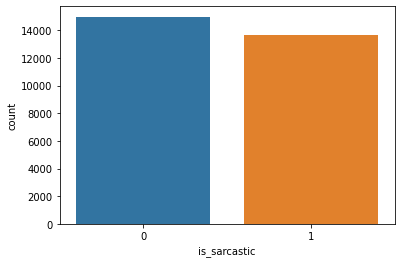

In [18]:
sns.countplot(sarcasm['is_sarcastic'])
sns.countplot(sarcasm2['is_sarcastic'])

In [19]:
nltk.download('stopwords')
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
sarcasm["headline"] = sarcasm["headline"].apply(clean)
sarcasm2["headline"] = sarcasm2["headline"].apply(clean)
print(sarcasm.head())
sarcasm2.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
                                            headline  is_sarcastic
0  former versac store clerk sue secret black cod...             0
1  roseann reviv catch thorni polit mood better wors             0
2  mom start fear son web seri closest thing gran...             1
3  boehner want wife listen come altern debtreduc...             1
4        jk rowl wish snape happi birthday magic way             0


,is_sarcastic,headline
0,1,thirtysometh scientist unveil doomsday clock h...
1,0,dem rep total nail congress fall short gender ...
2,0,eat veggi delici differ recip
3,1,inclement weather prevent liar get work
4,1,mother come pretti close use word stream correct


In [20]:
# First dataset training
data = sarcasm[["headline", "is_sarcastic"]]
x = np.array(data["headline"])
y = np.array(data["is_sarcastic"])

cv = CountVectorizer()
X = cv.fit_transform(x) # Fit the Data
# print(X.shape)
# print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# Second dataset training
data2 = sarcasm2[["headline", "is_sarcastic"]]
x2 = np.array(data2["headline"])
y2 = np.array(data2["is_sarcastic"])

cv2 = CountVectorizer()
X2 = cv2.fit_transform(x2) # Fit the Data

# Dimensions need to match
X2 = X2[:26709, :18833]
y2 = y2[:26709]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=42)

# Neural Network

In [21]:
mlp = MLPClassifier(
    hidden_layer_sizes=(50,),
    max_iter=10,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.1,
)
import warnings
from sklearn.exceptions import ConvergenceWarning

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(X_train, y_train)

print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))


Iteration 1, loss = 0.61307582
Iteration 2, loss = 0.46575738
Iteration 3, loss = 0.38805390
Iteration 4, loss = 0.33941708
Iteration 5, loss = 0.30035308
Iteration 6, loss = 0.26861403
Iteration 7, loss = 0.24084950
Iteration 8, loss = 0.21420804
Iteration 9, loss = 0.19123366
Iteration 10, loss = 0.17270608
Training set score: 0.959096
Test set score: 0.778173


In [22]:
mlp2 = MLPClassifier(
        solver= "sgd",
        learning_rate= "constant",
        momentum= 0,
        learning_rate_init= 0.2,
        max_iter=10,
        verbose=10,
)
import warnings
from sklearn.exceptions import ConvergenceWarning

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp2.fit(X_train, y_train)

    print("Training set score: %f" % mlp2.score(X_train, y_train))
    print("Test set score: %f" % mlp2.score(X_test, y_test))

Iteration 1, loss = 0.66781048
Iteration 2, loss = 0.61644453
Iteration 3, loss = 0.56627905
Iteration 4, loss = 0.52293403
Iteration 5, loss = 0.48597127
Iteration 6, loss = 0.45502225
Iteration 7, loss = 0.42911493
Iteration 8, loss = 0.40688965
Iteration 9, loss = 0.38728915
Iteration 10, loss = 0.37010346
Training set score: 0.854308
Test set score: 0.780232


In [23]:
mlp3 = MLPClassifier(
    solver= "sgd",
        learning_rate= "constant",
        momentum= 0.9,
        learning_rate_init= 0.2,
        max_iter=10,
        nesterovs_momentum = False,
        verbose=10,
)
import warnings
from sklearn.exceptions import ConvergenceWarning

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp3.fit(X_train, y_train)

    print("Training set score: %f" % mlp3.score(X_train, y_train))
    print("Test set score: %f" % mlp3.score(X_test, y_test))

Iteration 1, loss = 0.57880063
Iteration 2, loss = 0.42525967
Iteration 3, loss = 0.35048054
Iteration 4, loss = 0.30453466
Iteration 5, loss = 0.24875952
Iteration 6, loss = 0.20535170
Iteration 7, loss = 0.15402588
Iteration 8, loss = 0.11685313
Iteration 9, loss = 0.07853625
Iteration 10, loss = 0.05423101
Training set score: 0.996911
Test set score: 0.784912


In [24]:
mlp4 = MLPClassifier(
    solver= "sgd",
        learning_rate= "constant",
        momentum= 0.9,
        learning_rate_init= 0.2,
        max_iter=10,
        nesterovs_momentum = True,
        verbose=10,
)
import warnings
from sklearn.exceptions import ConvergenceWarning

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp4.fit(X_train, y_train)

print("Training set score: %f" % mlp4.score(X_train, y_train))
print("Test set score: %f" % mlp4.score(X_test, y_test))

Iteration 1, loss = 0.57557110
Iteration 2, loss = 0.41989710
Iteration 3, loss = 0.34751991
Iteration 4, loss = 0.29236207
Iteration 5, loss = 0.24217472
Iteration 6, loss = 0.19859147
Iteration 7, loss = 0.15224580
Iteration 8, loss = 0.11232996
Iteration 9, loss = 0.07817495
Iteration 10, loss = 0.05278597
Training set score: 0.996069
Test set score: 0.783602


In [25]:
mlp5 = MLPClassifier(
   solver= "sgd",
        learning_rate= "invscaling",
        momentum= 0,
        learning_rate_init= 0.2,
        max_iter=10,
        verbose=10,
)
import warnings
from sklearn.exceptions import ConvergenceWarning

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp5.fit(X_train, y_train)

    print("Training set score: %f" % mlp5.score(X_train, y_train))
    print("Test set score: %f" % mlp5.score(X_test, y_test))

Iteration 1, loss = 0.67239082
Iteration 2, loss = 0.64828532
Iteration 3, loss = 0.64798484
Iteration 4, loss = 0.64776063
Iteration 5, loss = 0.64757352
Iteration 6, loss = 0.64740947
Iteration 7, loss = 0.64726170
Iteration 8, loss = 0.64712601
Iteration 9, loss = 0.64699947
Iteration 10, loss = 0.64688075
Training set score: 0.616324
Test set score: 0.613628


In [26]:
mlp6 = MLPClassifier(
    solver= "sgd",
        learning_rate= "invscaling",
        momentum= 0.9,
        learning_rate_init= 0.2,
        max_iter=10,
        nesterovs_momentum = True,
        verbose=10,
)
import warnings
from sklearn.exceptions import ConvergenceWarning

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp6.fit(X_train, y_train)

    print("Training set score: %f" % mlp6.score(X_train, y_train))
    print("Test set score: %f" % mlp6.score(X_test, y_test))

Iteration 1, loss = 0.57365816
Iteration 2, loss = 0.42318281
Iteration 3, loss = 0.41679718
Iteration 4, loss = 0.41470521
Iteration 5, loss = 0.41313633
Iteration 6, loss = 0.41180045
Iteration 7, loss = 0.41069519
Iteration 8, loss = 0.40971842
Iteration 9, loss = 0.40883574
Iteration 10, loss = 0.40806304
Training set score: 0.820658
Test set score: 0.769562


In [27]:
mlp7 = MLPClassifier(
    solver= "sgd",
        learning_rate= "invscaling",
        momentum= 0.9,
        learning_rate_init= 0.2,
        max_iter=10,
        nesterovs_momentum = False,
        verbose=10,
)
import warnings
from sklearn.exceptions import ConvergenceWarning

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp7.fit(X_train, y_train)

    print("Training set score: %f" % mlp7.score(X_train, y_train))
    print("Test set score: %f" % mlp7.score(X_test, y_test))

Iteration 1, loss = 0.57400767
Iteration 2, loss = 0.70770957
Iteration 3, loss = 0.41861621
Iteration 4, loss = 0.41731758
Iteration 5, loss = 0.41627886
Iteration 6, loss = 0.41536039
Iteration 7, loss = 0.41458350
Iteration 8, loss = 0.41386921
Iteration 9, loss = 0.41320182
Iteration 10, loss = 0.41260660
Training set score: 0.818037
Test set score: 0.768626


In [28]:
mlp8 = MLPClassifier(
   solver= "adam",
        #learning_rate= "constant",
        momentum= 0,
        learning_rate_init= 0.01,
        max_iter=10,
        verbose=10,
)
import warnings
from sklearn.exceptions import ConvergenceWarning

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp8.fit(X_train, y_train)

    print("Training set score: %f" % mlp8.score(X_train, y_train))
    print("Test set score: %f" % mlp8.score(X_test, y_test))

Iteration 1, loss = 0.49914809
Iteration 2, loss = 0.25521641
Iteration 3, loss = 0.12237268
Iteration 4, loss = 0.05057157
Iteration 5, loss = 0.01979981
Iteration 6, loss = 0.01110314
Iteration 7, loss = 0.00825940
Iteration 8, loss = 0.00783116
Iteration 9, loss = 0.00645593
Iteration 10, loss = 0.00596203
Training set score: 0.999860
Test set score: 0.783976


In [29]:
mlp9 = MLPClassifier(
   solver= "adam",
        #learning_rate= "constant",
        #momentum= 0,
        learning_rate_init= 0.01,
        #max_iter=10,
        verbose=True,
)
import warnings
from sklearn.exceptions import ConvergenceWarning

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp9.fit(X_train, y_train)

    print("Training set score: %f" % mlp9.score(X_train, y_train))
    print("Test set score: %f" % mlp9.score(X_test, y_test))

Iteration 1, loss = 0.49745601
Iteration 2, loss = 0.24335304
Iteration 3, loss = 0.11693452
Iteration 4, loss = 0.04511686
Iteration 5, loss = 0.01691437
Iteration 6, loss = 0.00974539
Iteration 7, loss = 0.00759392
Iteration 8, loss = 0.00645894
Iteration 9, loss = 0.00586960
Iteration 10, loss = 0.00543988
Iteration 11, loss = 0.00509585
Iteration 12, loss = 0.00480084
Iteration 13, loss = 0.00452988
Iteration 14, loss = 0.00429165
Iteration 15, loss = 0.00407258
Iteration 16, loss = 0.00387105
Iteration 17, loss = 0.00367721
Iteration 18, loss = 0.00349939
Iteration 19, loss = 0.00333361
Iteration 20, loss = 0.00317721
Iteration 21, loss = 0.00303067
Iteration 22, loss = 0.00289479
Iteration 23, loss = 0.00276749
Iteration 24, loss = 0.00264558
Iteration 25, loss = 0.00252730
Iteration 26, loss = 0.00241578
Iteration 27, loss = 0.14308901
Iteration 28, loss = 0.14702753
Iteration 29, loss = 0.03126896
Iteration 30, loss = 0.01714027
Iteration 31, loss = 0.01511354
Iteration 32, los

In [30]:
pred_mlp = mlp.predict(X_test)
print(classification_report(y_test, pred_mlp))
print(confusion_matrix(y_test, pred_mlp))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      2996
           1       0.78      0.69      0.73      2346

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342

[[2529  467]
 [ 718 1628]]


In [31]:
pred_mlp = mlp.predict(X_test)
print(classification_report(y_test, pred_mlp))
print(confusion_matrix(y_test, pred_mlp))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      2996
           1       0.78      0.69      0.73      2346

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342

[[2529  467]
 [ 718 1628]]


In [32]:
pred_mlp2 = mlp2.predict(X_test)
print(classification_report(y_test, pred_mlp2))
print(confusion_matrix(y_test, pred_mlp2))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      2996
           1       0.80      0.66      0.73      2346

    accuracy                           0.78      5342
   macro avg       0.79      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342

[[2619  377]
 [ 797 1549]]


In [33]:
pred_mlp3 = mlp3.predict(X_test)
print(classification_report(y_test, pred_mlp3))
print(confusion_matrix(y_test, pred_mlp3))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      2996
           1       0.77      0.73      0.75      2346

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342

[[2487  509]
 [ 640 1706]]


In [34]:
pred_mlp4 = mlp4.predict(X_test)
print(classification_report(y_test, pred_mlp4))
print(confusion_matrix(y_test, pred_mlp4))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2996
           1       0.76      0.74      0.75      2346

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342

[[2454  542]
 [ 614 1732]]


In [35]:
pred_mlp5 = mlp5.predict(X_test)
print(classification_report(y_test, pred_mlp5))
print(confusion_matrix(y_test, pred_mlp5))

              precision    recall  f1-score   support

           0       0.59      0.98      0.74      2996
           1       0.86      0.14      0.25      2346

    accuracy                           0.61      5342
   macro avg       0.73      0.56      0.49      5342
weighted avg       0.71      0.61      0.52      5342

[[2943   53]
 [2011  335]]


In [36]:
pred_mlp6 = mlp6.predict(X_test)
print(classification_report(y_test, pred_mlp6))
print(confusion_matrix(y_test, pred_mlp6))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      2996
           1       0.77      0.68      0.72      2346

    accuracy                           0.77      5342
   macro avg       0.77      0.76      0.76      5342
weighted avg       0.77      0.77      0.77      5342

[[2513  483]
 [ 748 1598]]


In [37]:
pred_mlp7 = mlp7.predict(X_test)
print(classification_report(y_test, pred_mlp7))
print(confusion_matrix(y_test, pred_mlp7))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      2996
           1       0.77      0.68      0.72      2346

    accuracy                           0.77      5342
   macro avg       0.77      0.76      0.76      5342
weighted avg       0.77      0.77      0.77      5342

[[2517  479]
 [ 757 1589]]


In [38]:
pred_mlp8 = mlp8.predict(X_test)
print(classification_report(y_test, pred_mlp8))
print(confusion_matrix(y_test, pred_mlp8))

              precision    recall  f1-score   support

           0       0.79      0.85      0.81      2996
           1       0.78      0.71      0.74      2346

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342

[[2534  462]
 [ 692 1654]]


In [39]:
pred_mlp9 = mlp9.predict(X_test)
print(classification_report(y_test, pred_mlp9))
print(confusion_matrix(y_test, pred_mlp9))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      2996
           1       0.79      0.69      0.73      2346

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.77      5342
weighted avg       0.78      0.78      0.78      5342

[[2559  437]
 [ 736 1610]]


In [40]:
#Training on subset of dataset 1 and Testing on another mutually exlusive subset of dataset 1 
mlpc = MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=10000) #500 originally but did not converge
mlpc.fit(X_train, y_train)
pred_mlpc = mlpc.predict(X_test)

In [41]:
#Training on subset of dataset 2 and Testing on another mutually exlusive subset of dataset 2 
mlpc2 = MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=10000) #500 originally but did not converge
mlpc2.fit(X_train2, y_train2)
pred_mlpc2 = mlpc2.predict(X_test2)

In [42]:
#Training on subset of dataset 1 and Testing on another mutually exlusive subset of dataset 2 
mlpc3 = MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=10000) #500 originally but did not converge
mlpc3.fit(X_train, y_train)
pred_mlpc3 = mlpc3.predict(X_test2)

In [43]:
#Training on dataset 1 and testing on dataset 1
model = MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=10000)
model.fit(X_train, y_train)
pred_model = model.predict(X_test)

In [44]:
#Training on dataset 2 and testing on dataset 1 
model2 = MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=10000)
model2.fit(X_train2, y_train2)
pred_model2 = model2.predict(X_test)
#print(model2.score(X_test, y_test))

In [45]:
print(classification_report(y_test, pred_mlpc))
print(confusion_matrix(y_test, pred_mlpc))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      2996
           1       0.73      0.70      0.71      2346

    accuracy                           0.75      5342
   macro avg       0.75      0.75      0.75      5342
weighted avg       0.75      0.75      0.75      5342

[[2384  612]
 [ 705 1641]]


In [46]:
print(classification_report(y_test, pred_mlpc2))
print(confusion_matrix(y_test, pred_mlpc2))

              precision    recall  f1-score   support

           0       0.56      0.55      0.56      2996
           1       0.44      0.46      0.45      2346

    accuracy                           0.51      5342
   macro avg       0.50      0.50      0.50      5342
weighted avg       0.51      0.51      0.51      5342

[[1643 1353]
 [1268 1078]]


In [47]:
print(classification_report(y_test2, pred_mlpc3))
print(confusion_matrix(y_test2, pred_mlpc3))

              precision    recall  f1-score   support

           0       0.51      0.55      0.53      2766
           1       0.48      0.44      0.46      2576

    accuracy                           0.50      5342
   macro avg       0.50      0.50      0.50      5342
weighted avg       0.50      0.50      0.50      5342

[[1515 1251]
 [1430 1146]]


In [48]:
print(classification_report(y_test2, pred_mlpc2))
print(confusion_matrix(y_test2, pred_mlpc2))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      2766
           1       0.75      0.71      0.73      2576

    accuracy                           0.74      5342
   macro avg       0.74      0.74      0.74      5342
weighted avg       0.74      0.74      0.74      5342

[[2154  612]
 [ 757 1819]]


In [49]:
print(classification_report(y_test2, pred_model))
print(confusion_matrix(y_test2, pred_model))

              precision    recall  f1-score   support

           0       0.51      0.58      0.54      2766
           1       0.48      0.41      0.44      2576

    accuracy                           0.50      5342
   macro avg       0.50      0.50      0.49      5342
weighted avg       0.50      0.50      0.50      5342

[[1597 1169]
 [1511 1065]]


In [50]:
print(classification_report(y_test, pred_model2))
print(confusion_matrix(y_test, pred_model2))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58      2996
           1       0.45      0.42      0.44      2346

    accuracy                           0.52      5342
   macro avg       0.51      0.51      0.51      5342
weighted avg       0.52      0.52      0.52      5342

[[1776 1220]
 [1349  997]]


# Accuracy Scores

In [61]:
cm = accuracy_score(y_test, pred_mlp)
print(mlp.score(X_test, y_test))
cm


0.778172968925496


0.778172968925496

In [62]:
cm = accuracy_score(y_test, pred_mlp2)
cm

0.7802321228004493

In [63]:
cm = accuracy_score(y_test, pred_mlp3)
cm

0.7849120179707975

In [64]:
cm = accuracy_score(y_test, pred_mlp4)
cm

0.7836016473231

In [65]:
cm = accuracy_score(y_test, pred_mlp5)
cm

0.6136278547360539

In [66]:
cm = accuracy_score(y_test, pred_mlp6)
cm

0.7695619618120554

In [67]:
cm = accuracy_score(y_test, pred_mlp7)
cm

0.7686259827779858

In [68]:
cm = accuracy_score(y_test, pred_mlp8)
cm

0.7839760389367278

In [69]:
cm = accuracy_score(y_test, pred_mlp9)
cm

0.7804193186072632

# Single sentence predictors

In [60]:
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = mlpc.predict(data)
if output == 1:
    print('sarcastic')
else: 
    print ('genuine')

Enter a Text: i like spastic pizza on my ass
sarcastic
